# APC CAS_KAGGLE ALCOHOL

* JAN PLANAS BATLLORI
* NIU: 1636492

### Student Alcohol Consumption

[Kaggle Dataset](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption/data)

En aquest ficher resoldre un problema de classificació el qual haurè de predir les notes de matemàtiques i de portugues dels alumnes. 

#### INCLUDES

In [26]:
import numpy as np
import pandas as pd
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve, roc_auc_score, auc, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, classification_report

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
#%pip install hdbscan
#import hdbscan

import warnings
warnings.filterwarnings("ignore")

### EDA

In [19]:
math_data = pd.read_csv("student-mat.csv")
por_data = pd.read_csv("student-por.csv")

df = pd.concat([math_data, por_data], ignore_index=True)

df.info()
print(f"El shape del train-data es {df.shape}.")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
print(df.isna().sum().sum())

0


Farem un primer anàlisi dels atribut que tenim i els calssificarem en categòrics i numèrics.  

In [20]:
categorics = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numerics = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
targets = ['G1', 'G2', 'G3']


Balanceig numerics.

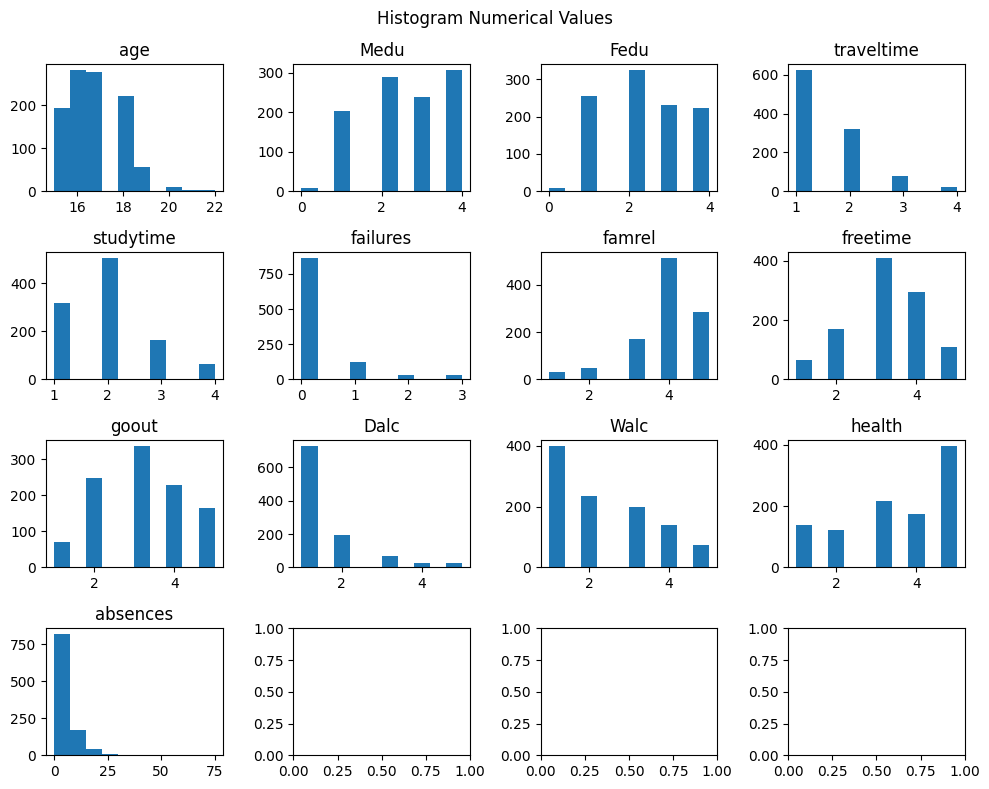

In [7]:
df_num = df[numerics]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Balanceig categorics.

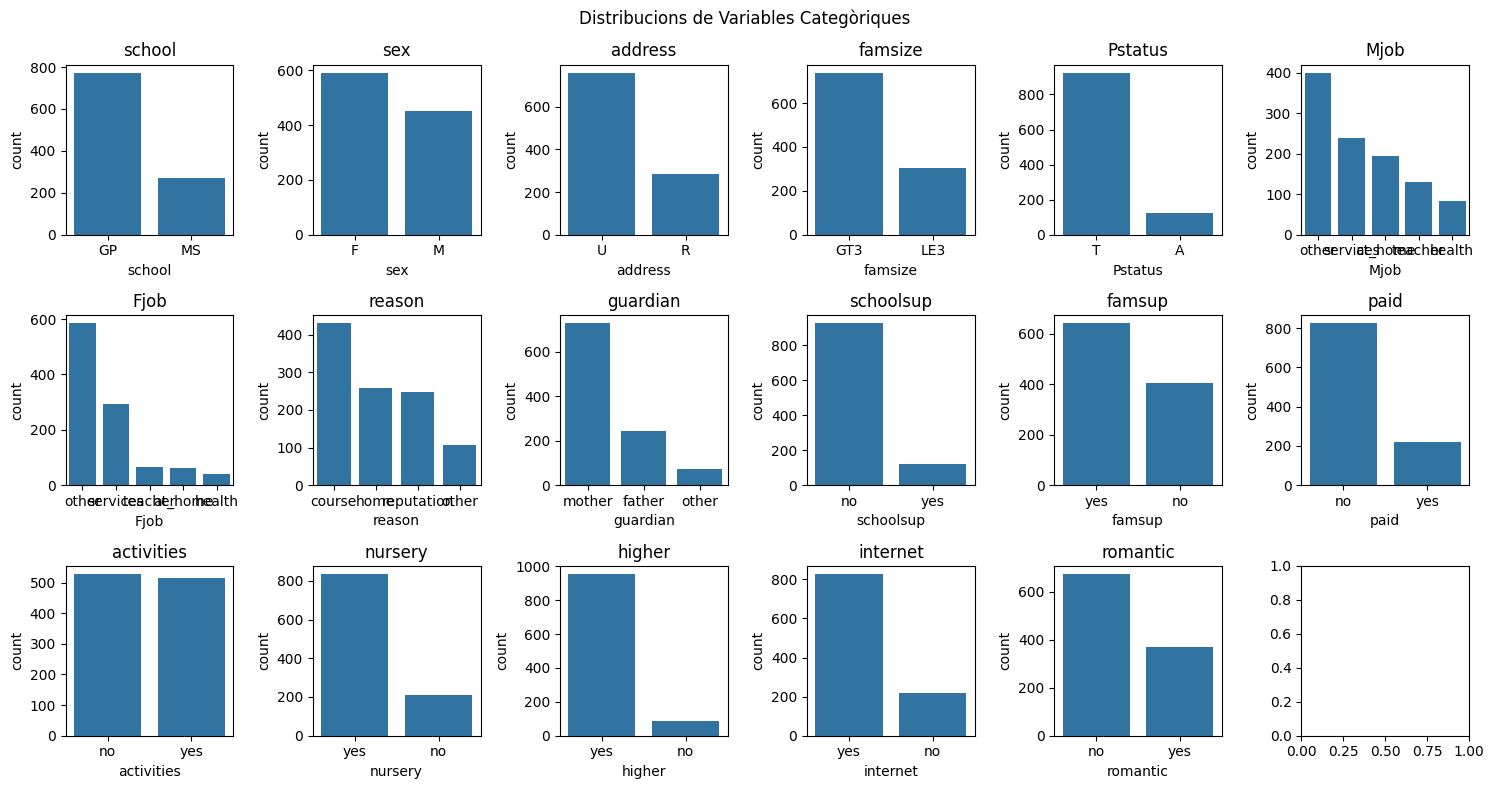

In [10]:
df_cat = df[categorics]
fig, axes = plt.subplots(3, 6, figsize=(15, 8))
fig.suptitle('Distribucions de Variables Categòriques')

for i, ax in enumerate(axes.ravel()):
    if i < df_cat.shape[1]:
        column_name = df_cat.columns[i]
        sns.barplot(x=df_cat[column_name].value_counts().index, y=df_cat[column_name].value_counts(), ax=ax)
        ax.set_ylabel('count')
        ax.set_title(column_name)

plt.tight_layout()
plt.show()

Balanceig targets.

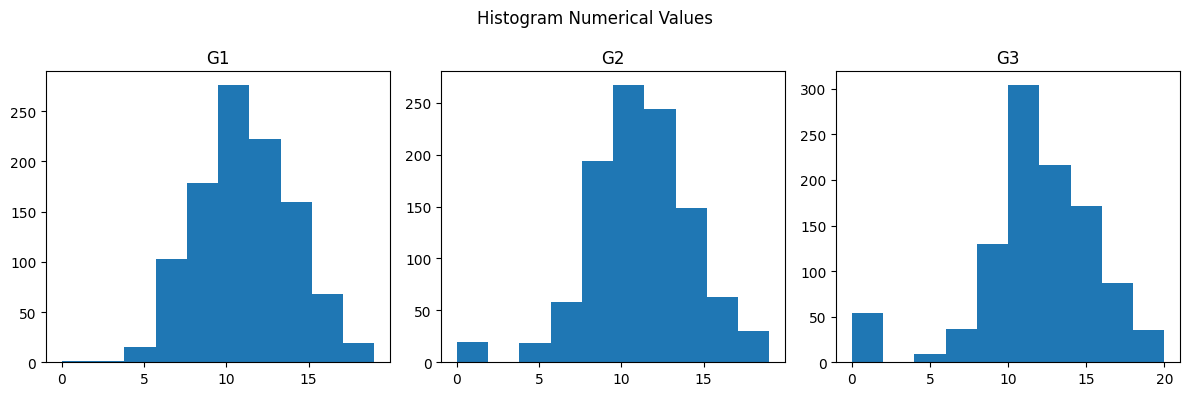

In [24]:
df_targ = df[targets]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_targ.columns, axes.ravel()):
    ax.hist(df_targ[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Mirare la quantitat de 0 que hi ha en cada G ja que em pot fer sospitar que es degui a l'abandonament per part dels estudiants del curs al veures els G anteriors suspesos.

In [62]:
for target in targets:
    count_zeros = df[df[target] == 0].shape[0]
    print(f"Para el target '{target}' hay {count_zeros} valores '0'")

Para el target 'G1' hay 1 valores '0'
Para el target 'G2' hay 20 valores '0'
Para el target 'G3' hay 53 valores '0'


In [73]:
count_combinations = defaultdict(lambda: {'Aprobado': defaultdict(int), 'Suspendido': defaultdict(int)})

for index, row in df.iterrows():
    if any(row[target] == 0 for target in targets):
        for target in targets:
            if row[target] == 0:
                other_targets = [col for col in targets if col != target]
                for other_target in other_targets:
                    if row[other_target] > 9:
                        count_combinations[target]['Aprobado'][other_target] += 1
                    else:
                        count_combinations[target]['Suspendido'][other_target] += 1

# Mostrar el recuento de combinaciones para cada target que sea 0
print("Recuento de combinaciones para cada target que sea 0 dividido por otros targets:")
for target, counts in count_combinations.items():
    print(f"Para el target '{target}':")
    for key, value in counts.items():
        print(f"- {key}:")
        for other_target, count in value.items():
            print(f"   * {other_target}: {count}")


Recuento de combinaciones para cada target que sea 0 dividido por otros targets:
Para el target 'G3':
- Aprobado:
   * G1: 8
   * G2: 2
- Suspendido:
   * G1: 45
   * G2: 51
Para el target 'G2':
- Aprobado:
   * G1: 3
- Suspendido:
   * G3: 20
   * G1: 17
Para el target 'G1':
- Aprobado:
   * G2: 1
   * G3: 1
- Suspendido:


In [74]:
for target in targets:
    rows_with_zero = df[df[target] == 0]
    print(f"\nPara el target '{target}':")
    for index, row in rows_with_zero.iterrows():
        print(f"Valor '0' en '{target}', valor de 'absences': {row['absences']}")



Para el target 'G1':
Valor '0' en 'G1', valor de 'absences': 4

Para el target 'G2':
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0

Para el target 'G3':
Valor '0' en 'G3', valor de 'absences': 0
Valor '0' 

In [90]:
filtered_data = df[df['G3'] == 0]
numericsG1, numericsG2, numericsG3 = numerics.copy(), numerics.copy(), numerics.copy()

numericsG1.insert(0, 'G1')
numericsG2.insert(0, 'G2')
numericsG3.insert(0, 'G3')
filtered_data = filtered_data[numericsG3]

# Separar las características
X = filtered_data.drop(['G3'], axis=1)

# Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Aplicar HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True)
cluster_labels = clusterer.fit_predict(X_pca)

# Visualización de los clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters encontrados por HDBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

NameError: name 'hdbscan' is not defined

Correlacio numerics

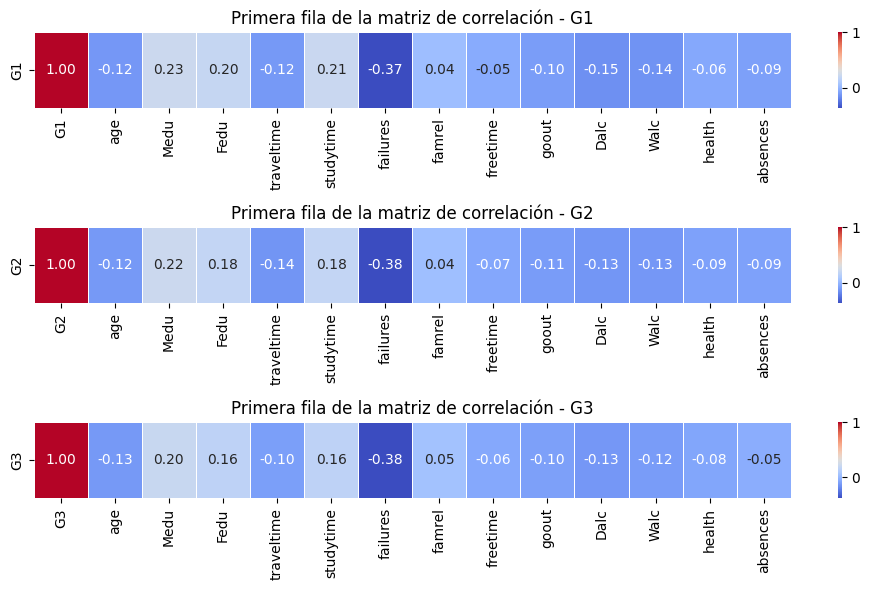

In [78]:
numericsG1, numericsG2, numericsG3 = numerics.copy(), numerics.copy(), numerics.copy()

numericsG1.insert(0, 'G1')
numericsG2.insert(0, 'G2')
numericsG3.insert(0, 'G3')

# Calcular la matriz de correlación para G1
correlation_matrix_G1 = df[numericsG1].corr()
first_row_correlation_G1 = correlation_matrix_G1.iloc[[0]]

# Calcular la matriz de correlación para G2
correlation_matrix_G2 = df[numericsG2].corr()
first_row_correlation_G2 = correlation_matrix_G2.iloc[[0]]

# Calcular la matriz de correlación para G3
correlation_matrix_G3 = df[numericsG3].corr()
first_row_correlation_G3 = correlation_matrix_G3.iloc[[0]]

# Mostrar las primeras filas de las matrices de correlación para G1, G2 y G3 en filas separadas
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
sns.heatmap(first_row_correlation_G1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Primera fila de la matriz de correlación - G1')

plt.subplot(3, 1, 2)
sns.heatmap(first_row_correlation_G2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Primera fila de la matriz de correlación - G2')

plt.subplot(3, 1, 3)
sns.heatmap(first_row_correlation_G3, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Primera fila de la matriz de correlación - G3')

plt.tight_layout()
plt.show()

Correlacio categoric

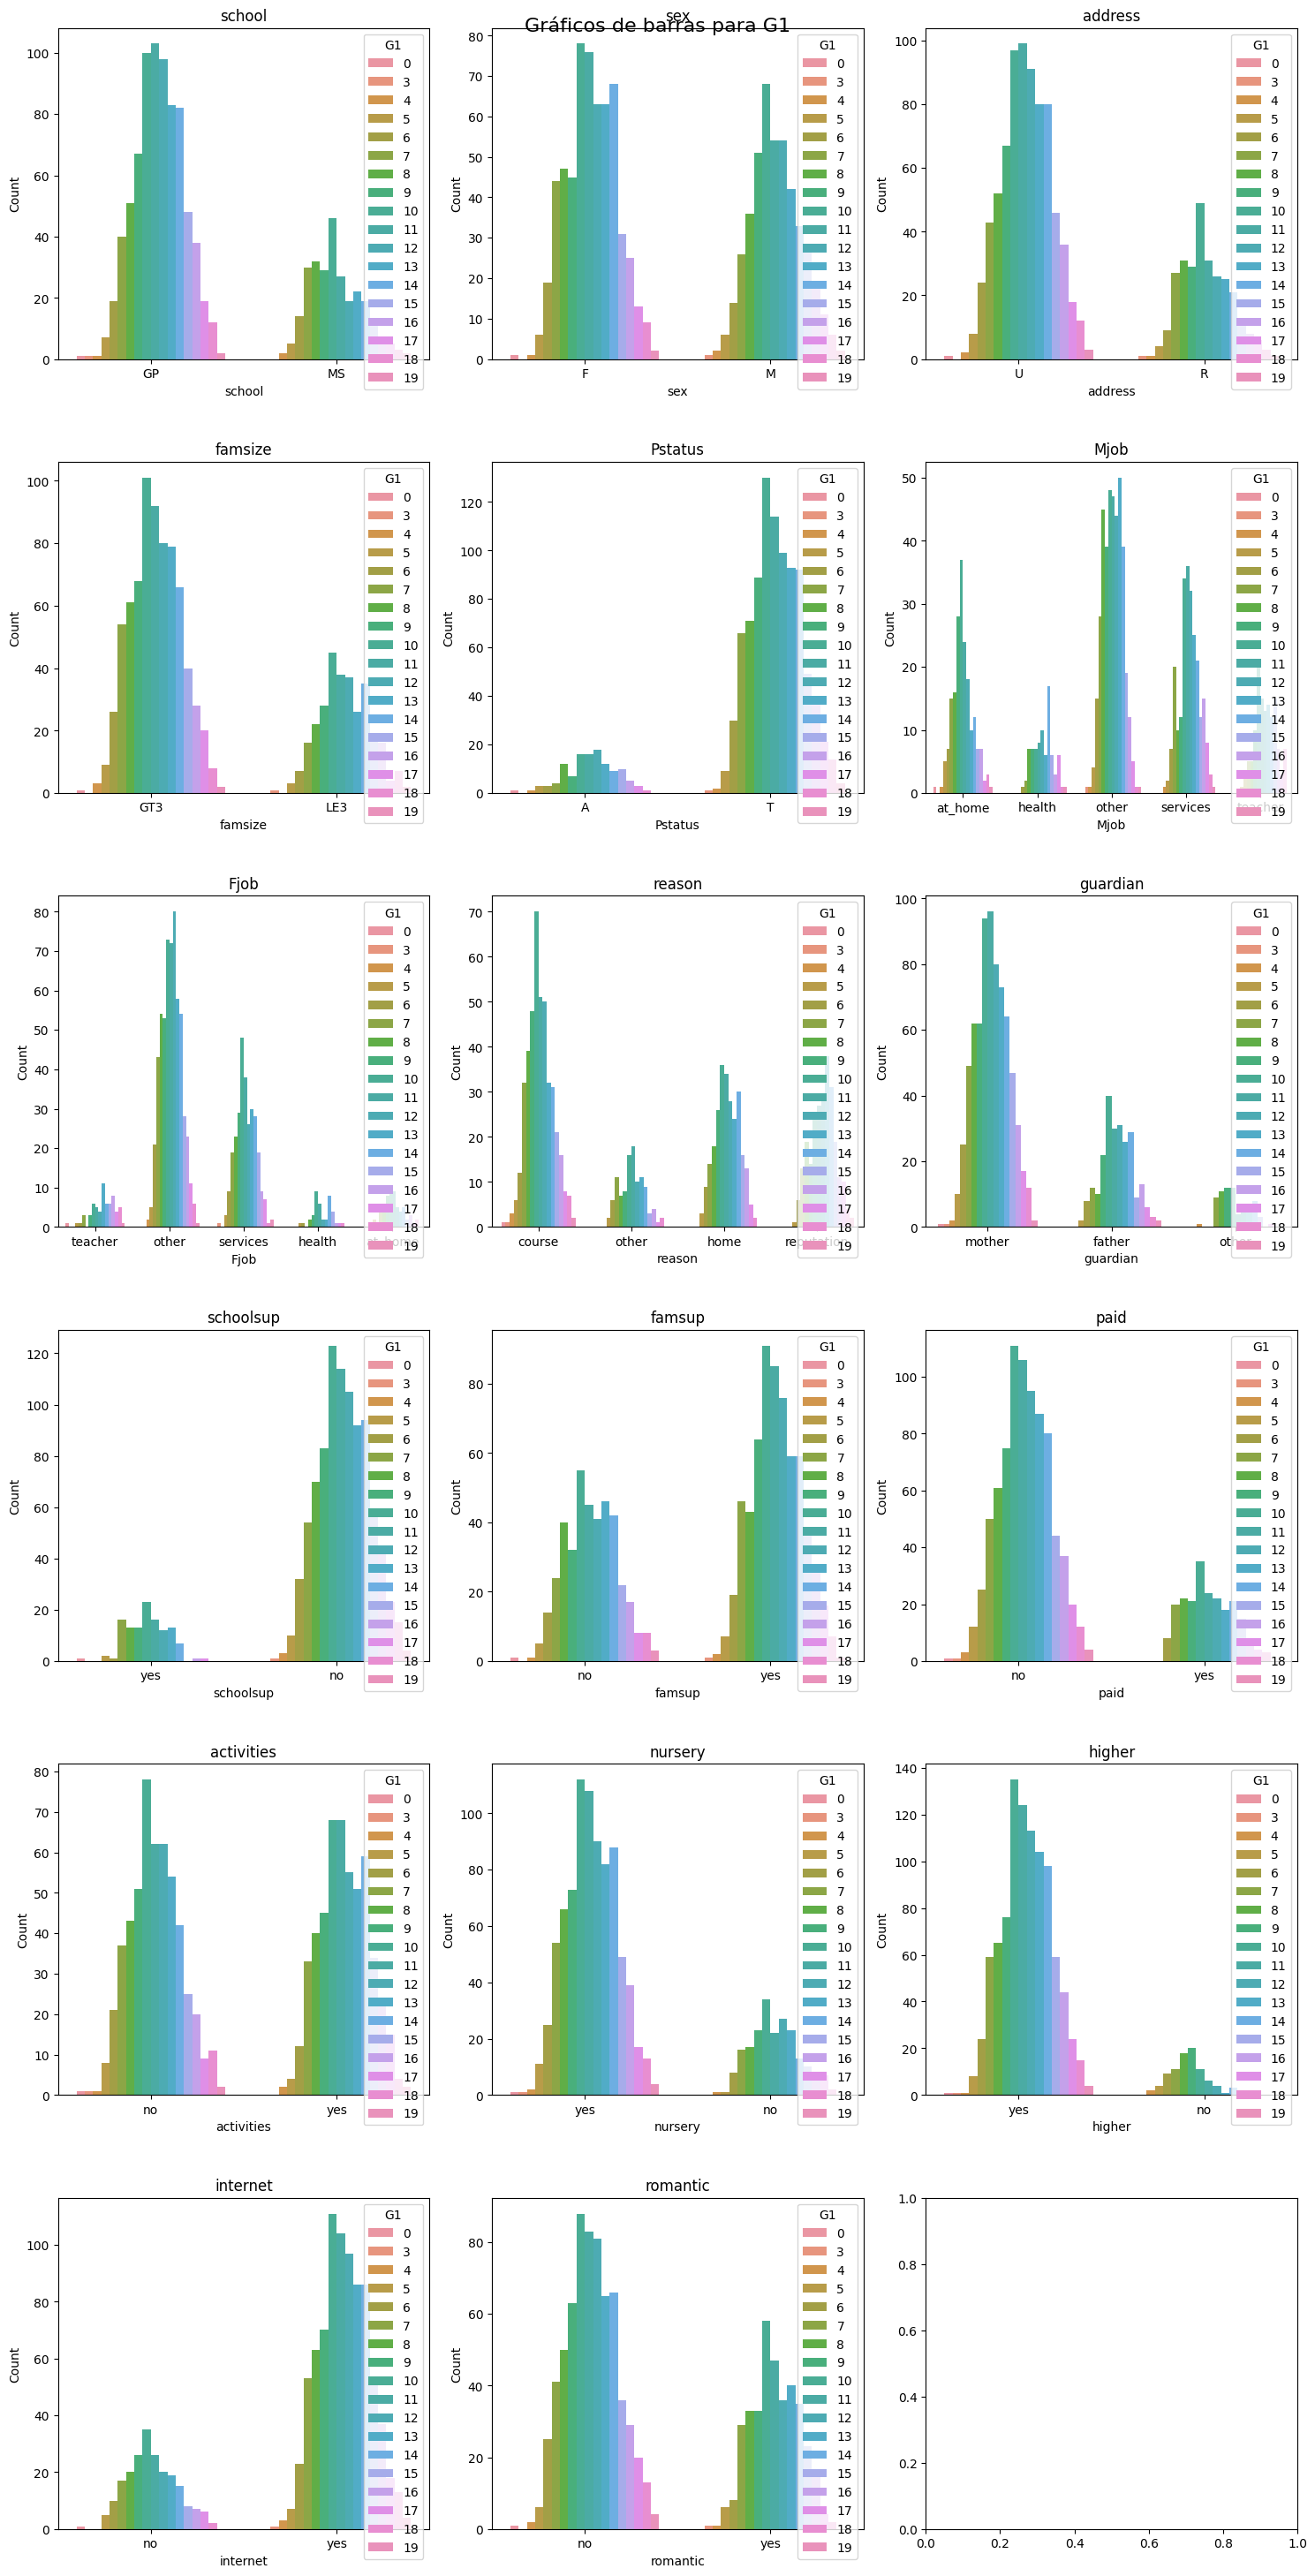

In [60]:
target = 'G1'  # Reemplaza 'G1' con el valor de tu primer target

n = len(categorics)
cols = 3  # Número de columnas por fila
rows = (n + cols - 1) // cols  # Calcular el número de filas necesarias

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Establecer el tamaño general de la figura
fig.suptitle(f'Gráficos de barras para {target}', fontsize=16)

for i, categoric in enumerate(categorics, start=0):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]  # Manejo de subplots si solo hay una fila

    sns.countplot(x=categoric, hue=target, data=df, ax=ax)
    ax.set_xlabel(categoric)
    ax.set_ylabel('Count')
    ax.set_title(f'{categoric}')
    ax.legend(title=target, loc='upper right')

plt.tight_layout()
plt.show()

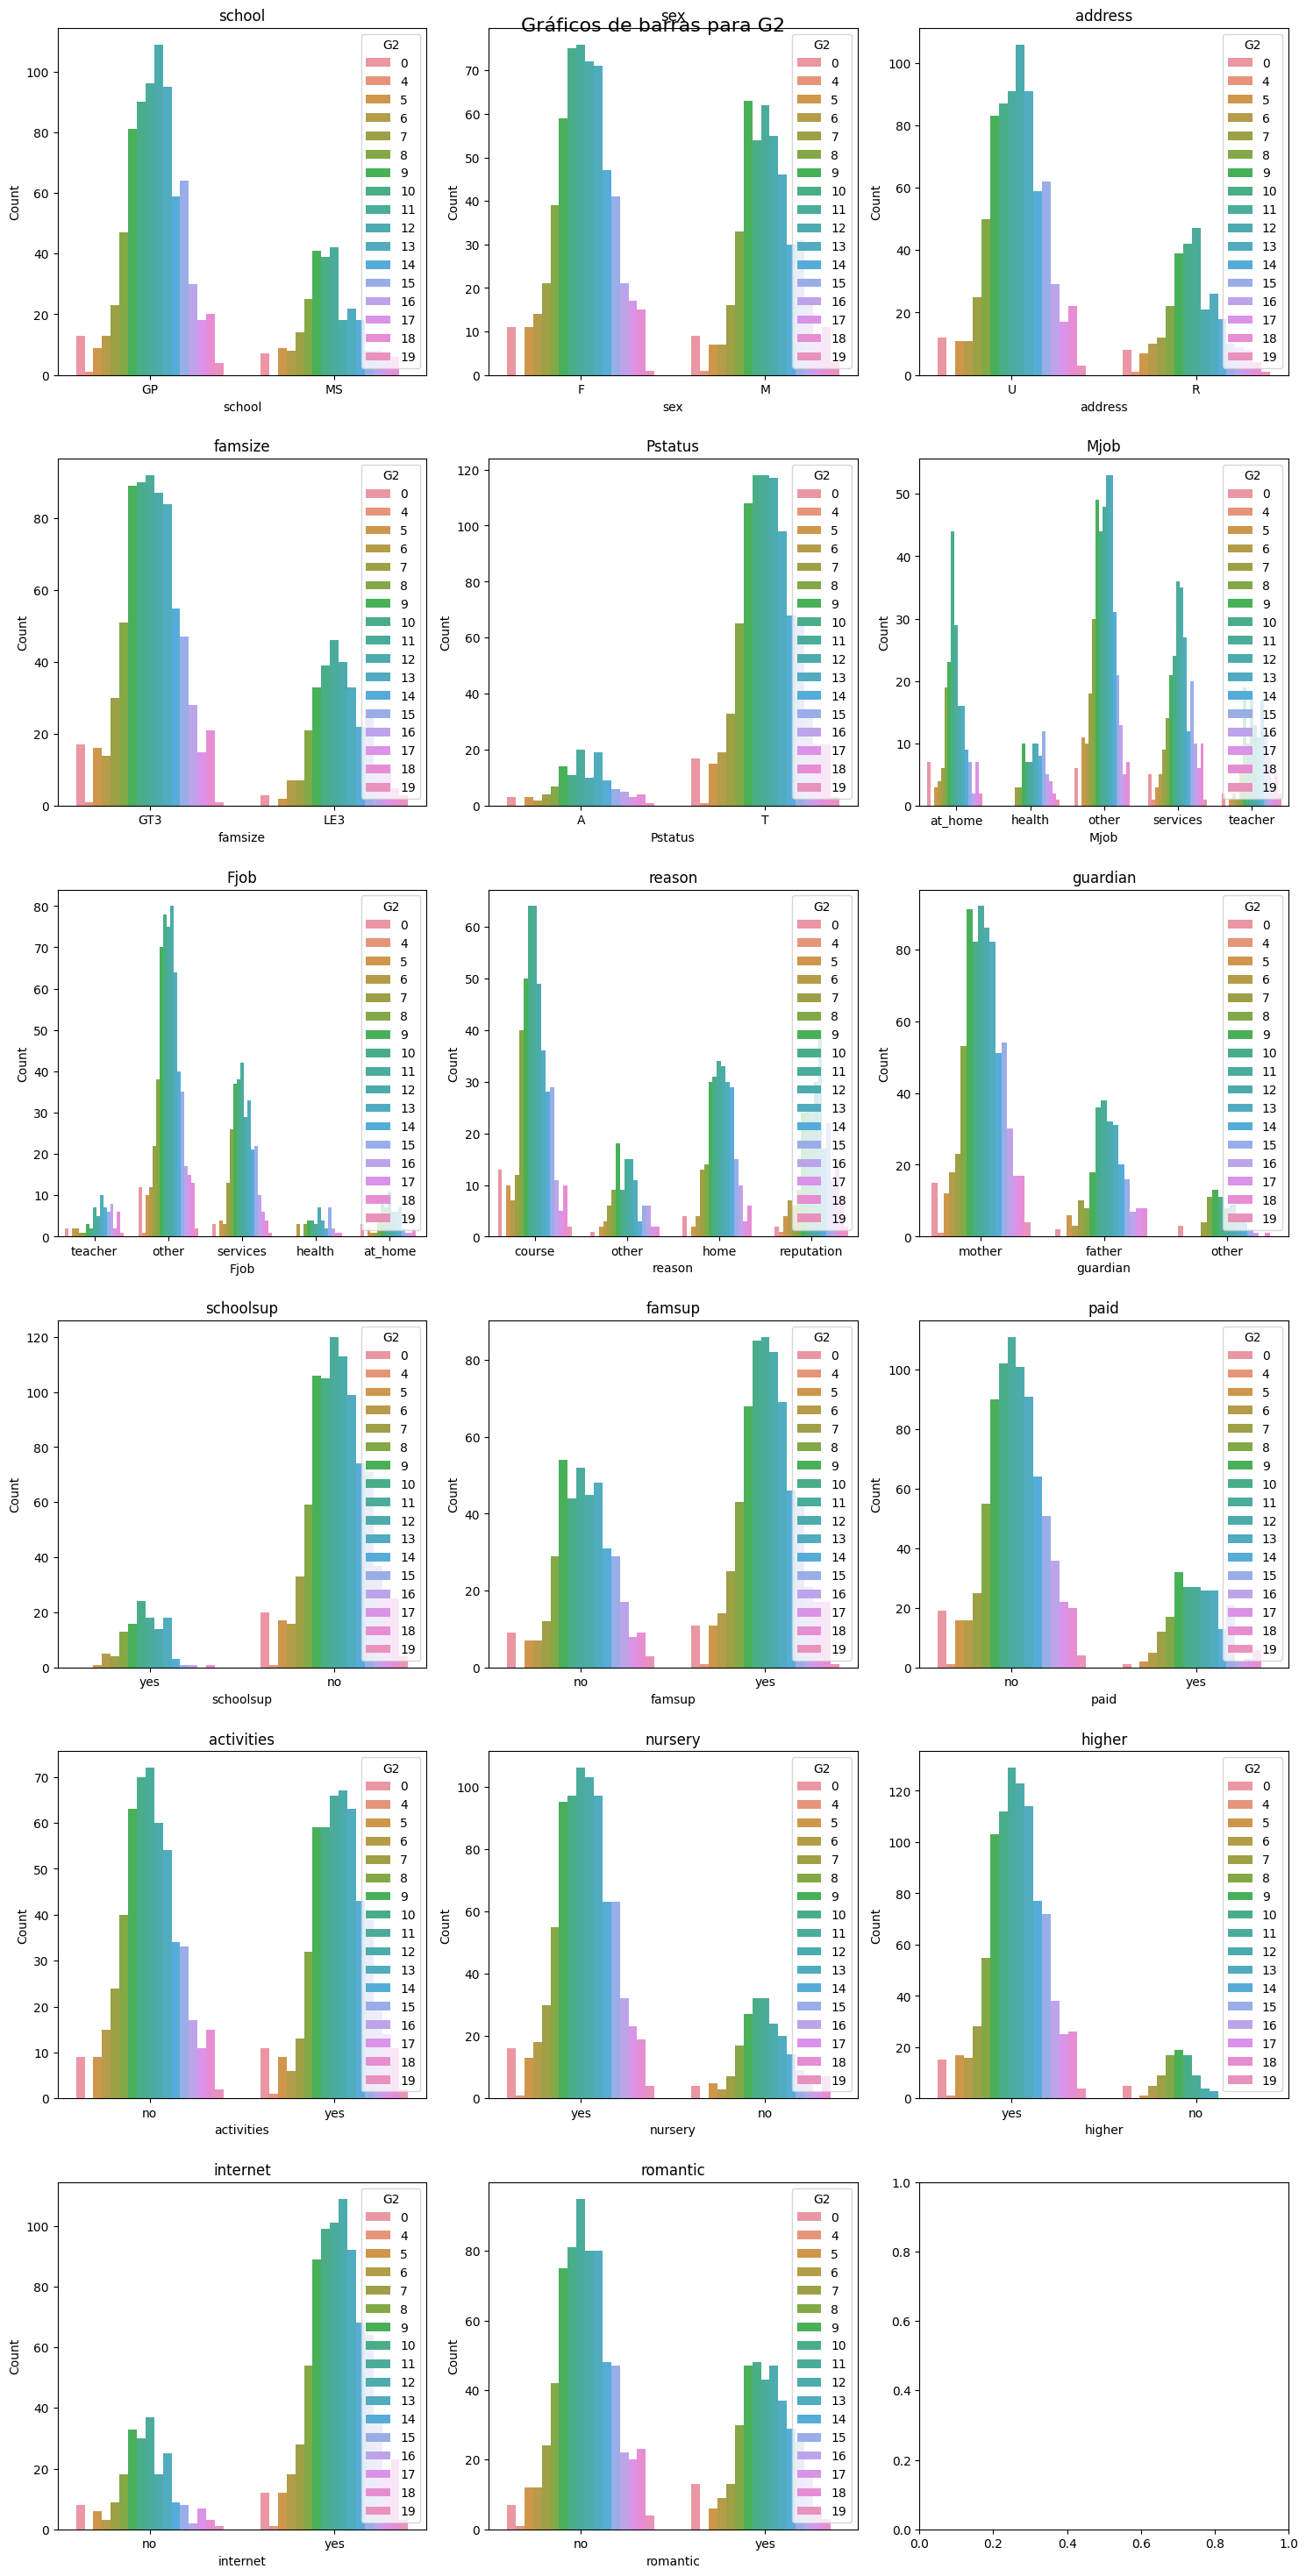

In [61]:
target = 'G2'  # Reemplaza 'G1' con el valor de tu primer target

n = len(categorics)
cols = 3  # Número de columnas por fila
rows = (n + cols - 1) // cols  # Calcular el número de filas necesarias

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Establecer el tamaño general de la figura
fig.suptitle(f'Gráficos de barras para {target}', fontsize=16)

for i, categoric in enumerate(categorics, start=0):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]  # Manejo de subplots si solo hay una fila

    sns.countplot(x=categoric, hue=target, data=df, ax=ax)
    ax.set_xlabel(categoric)
    ax.set_ylabel('Count')
    ax.set_title(f'{categoric}')
    ax.legend(title=target, loc='upper right')

plt.tight_layout()
plt.show()

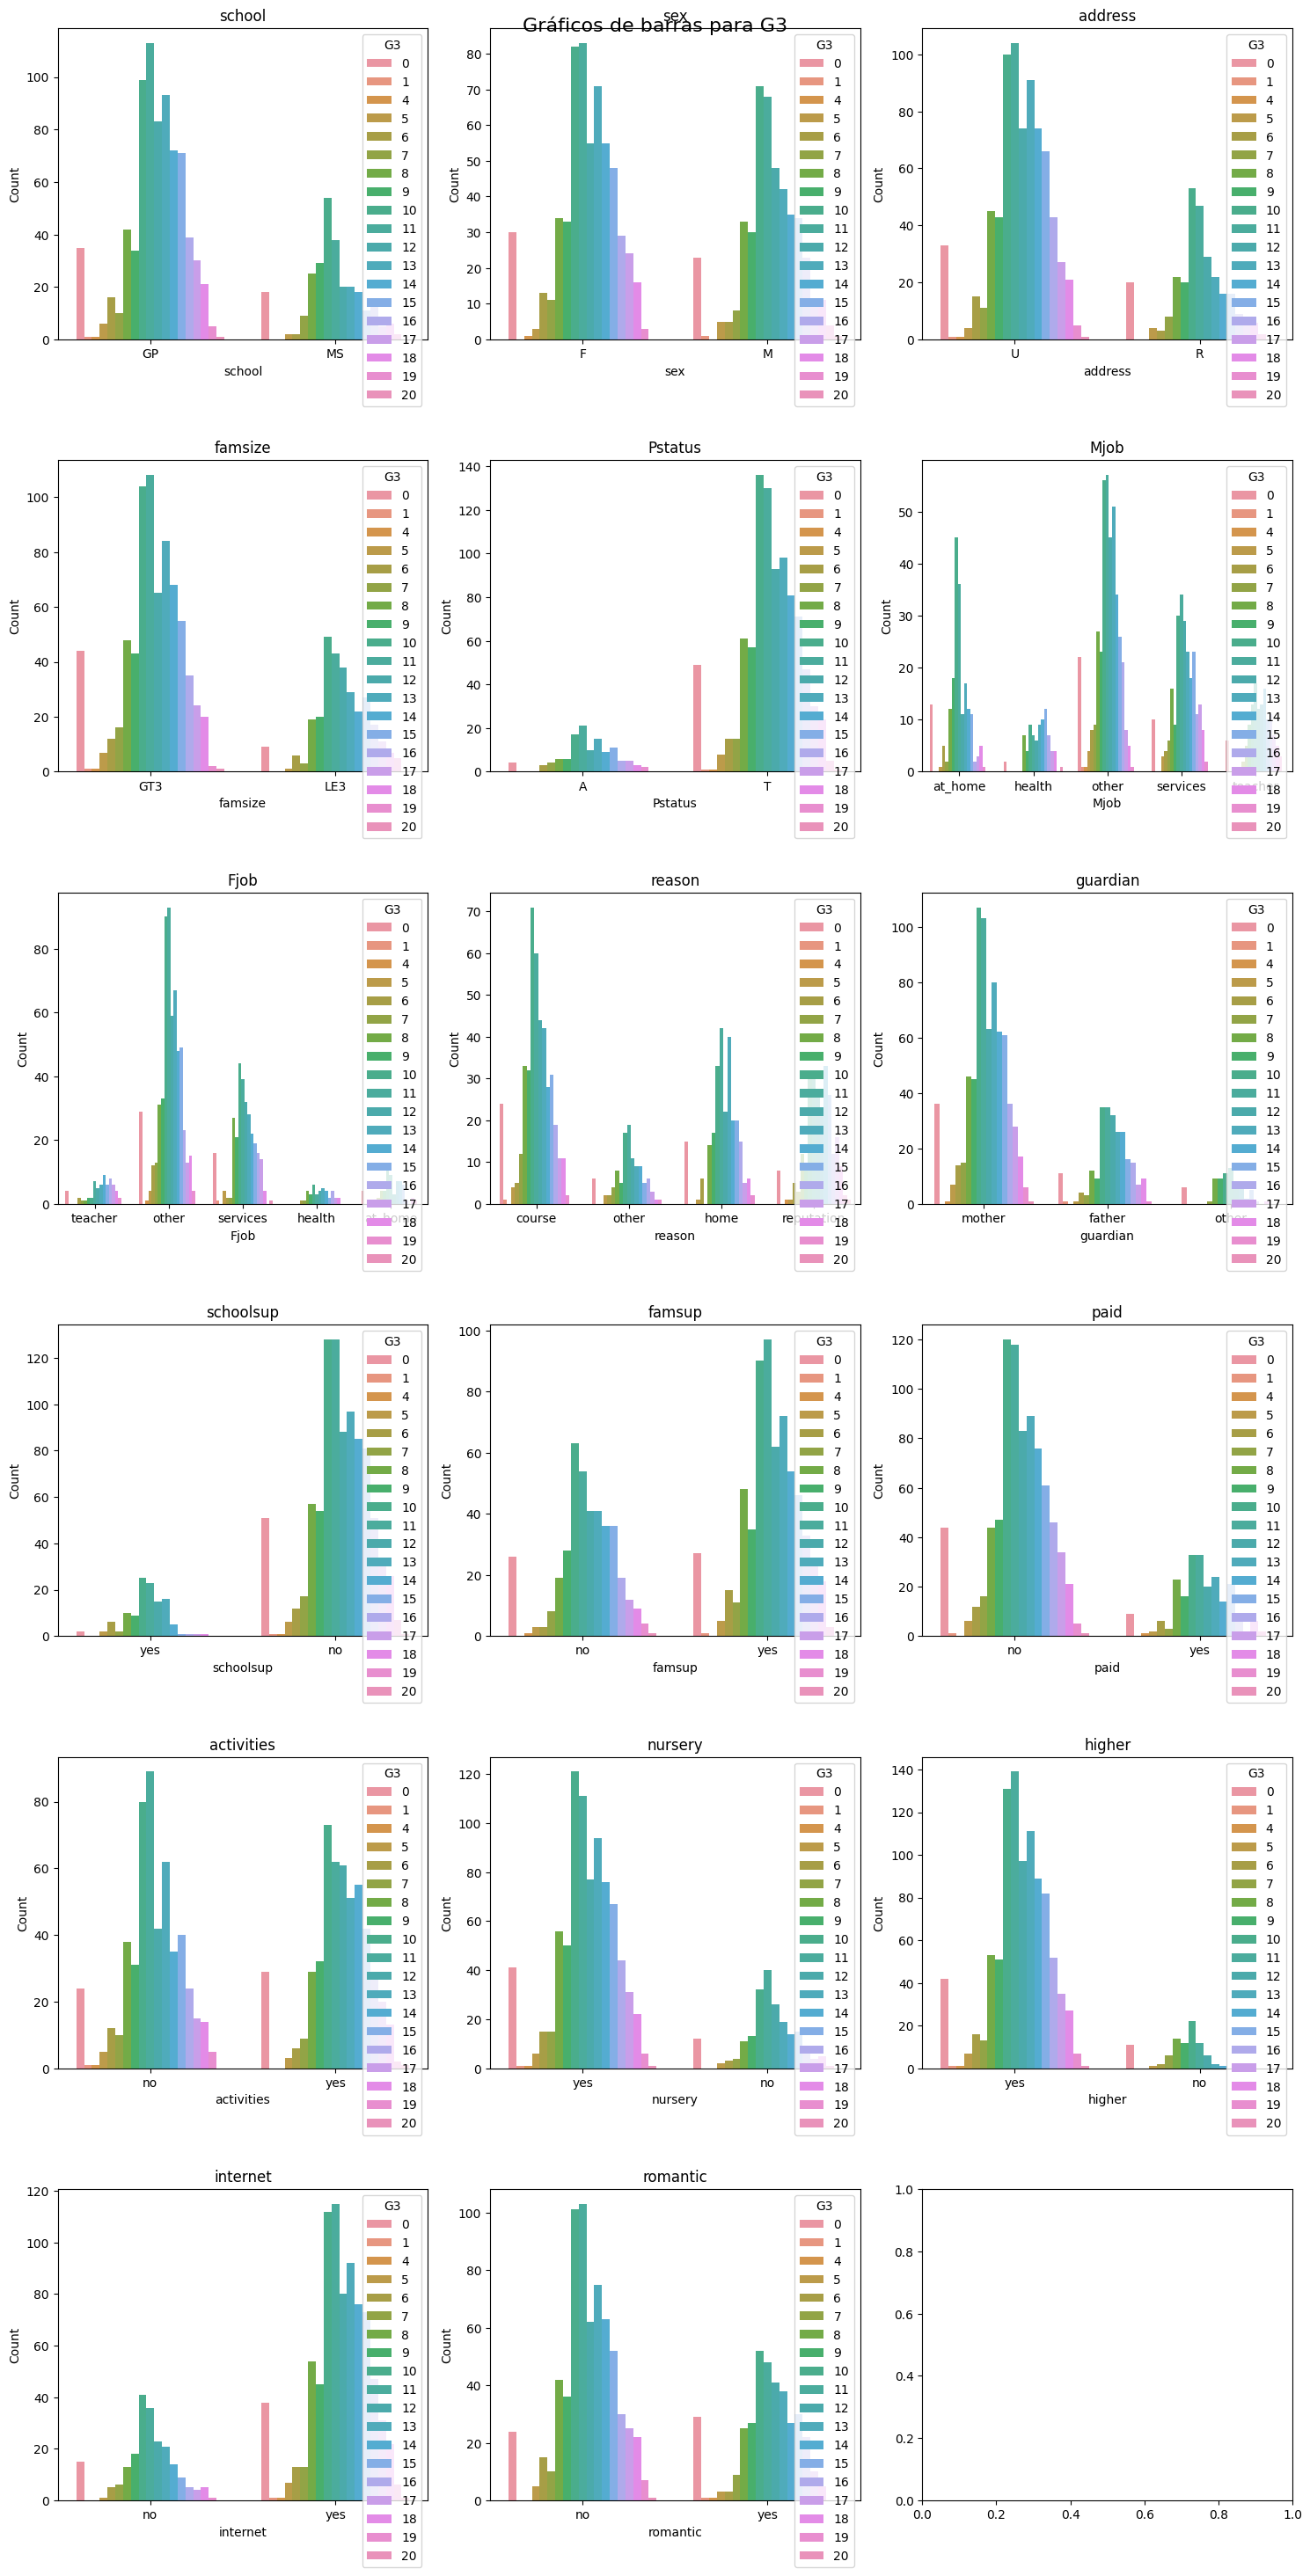

In [59]:
target = 'G3'  # Reemplaza 'G1' con el valor de tu primer target

n = len(categorics)
cols = 3  # Número de columnas por fila
rows = (n + cols - 1) // cols  # Calcular el número de filas necesarias

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Establecer el tamaño general de la figura
fig.suptitle(f'Gráficos de barras para {target}', fontsize=16)

for i, categoric in enumerate(categorics, start=0):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]  # Manejo de subplots si solo hay una fila

    sns.countplot(x=categoric, hue=target, data=df, ax=ax)
    ax.set_xlabel(categoric)
    ax.set_ylabel('Count')
    ax.set_title(f'{categoric}')
    ax.legend(title=target, loc='upper right')

plt.tight_layout()
plt.show()

### PROCESSING

#### FEATURE SELECTION

#### DECICIR QUIN DELS DOS

He decidit quedarme amb tots els atributs del dataset ja que trobo que tots tenen rellevància per al model, encara que alguns més que altres, i tot i tenir bastants atributs categòrics després de fer una primera exploració no veig que tingui cap problema per a codificar, ja que la majoria són binaris.

He decidit quedarme amb tots els atributs del dataset menys amb el atribut nursery ja que trobo que tots tenen rellevància per al model, encara que alguns més que altres, i tot i tenir bastants atributs categòrics després de fer una primera exploració no veig que tingui cap problema per a codificar, ja que la majoria són binaris.

In [ ]:
df = df.drop(['nursery'], axis=1)

#### NORMALITZACIO

El primer que farem serà normalitzar logaritmicament les dades per a que tingui una distribució normal el més semblant possible. Seguidament, escalarem les dades per a que vagin de 0 a 1 com a minim i màxim, amb el Min-Max Scaling.

La normalització logarítmica s'utilitza per transformar dades amb distribucions sesgades o una ampla variabilitat, reduint el sesgament i l'amplitud dels valors. Ajudar a igualar la distribució, estabilitzar la variància, facilitar la interpretació i preparar les dades per a certs models, però la seva aplicabilitat depèn de la naturalesa de les dades i del context del problema.

In [21]:
numerics_norm = [numeric + '_norm' for numeric in numerics]
for nums, nums_norm in zip(numerics, numerics_norm):
    df[nums_norm] = np.log1p(df[nums])

La funció principal del MinMaxScale és escalar les dades entre un rang específic, en aquest cas entre 0 i 1.  
El MinMaxScaler es una técnica de escalado que transforma los datos de tal manera que quedan en un rango específico, generalmente entre 0 y 1. Ens facilita la seva comparació ja que tots les variables categoriques tenen el mateix rang de dades.

In [22]:
scaler = MinMaxScaler()
df[numerics_norm] = scaler.fit_transform(df[numerics_norm])
df.isna().sum()

school             0
sex                0
age                0
address            0
famsize            0
Pstatus            0
Medu               0
Fedu               0
Mjob               0
Fjob               0
reason             0
guardian           0
traveltime         0
studytime          0
failures           0
schoolsup          0
famsup             0
paid               0
activities         0
nursery            0
higher             0
internet           0
romantic           0
famrel             0
freetime           0
goout              0
Dalc               0
Walc               0
health             0
absences           0
G1                 0
G2                 0
G3                 0
age_norm           0
Medu_norm          0
Fedu_norm          0
traveltime_norm    0
studytime_norm     0
failures_norm      0
famrel_norm        0
freetime_norm      0
goout_norm         0
Dalc_norm          0
Walc_norm          0
health_norm        0
absences_norm      0
dtype: int64

In [24]:
df = df.drop(numerics, axis=1)

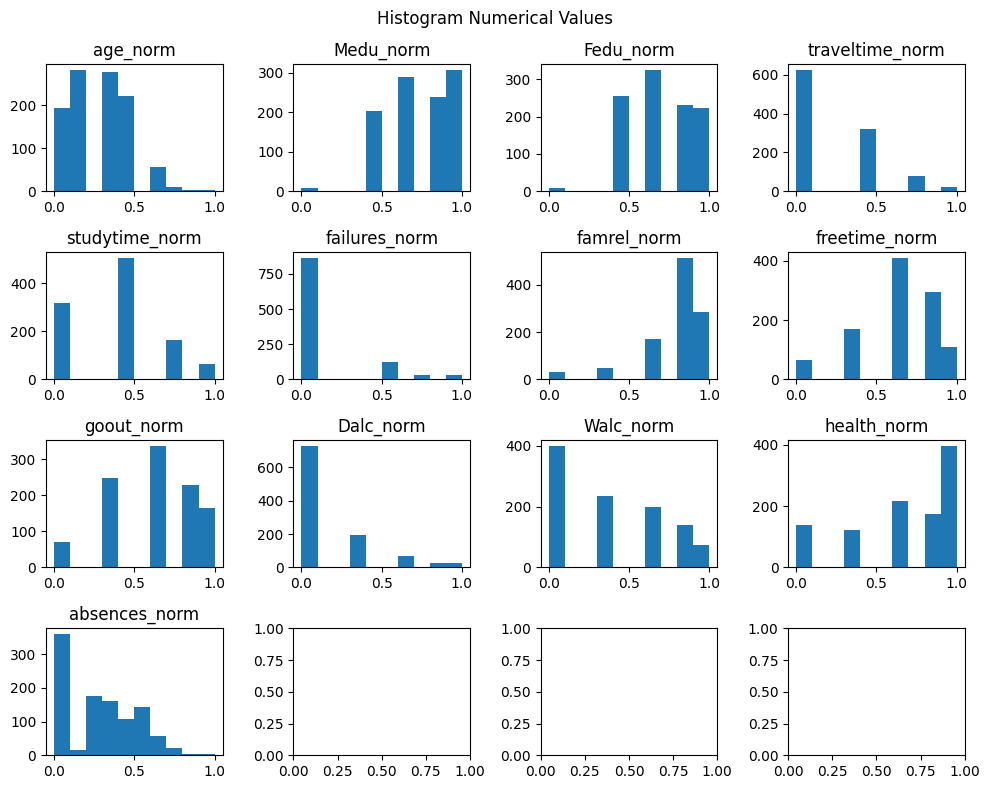

In [25]:
df_num = df[numerics_norm]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

#### ENCODING

Per a aquest apartat he decidit fer dos tipus d'encoding. Fare sevir el LabelEncoder per als atributs binaris i el OneHotEncoding per als altre.  
Això ho faig perque el LabelEncoder pot, avegades, afegir un ordre intrinsic que no existeix realment en les dades del dataset i es per això que pels atributs que no son binaris he decidit fer servir el OneHotEncoder. One Hot Encoder ens afegeix una columna nova per cadascuna de les classes de la columna codificada i posa un 1 a la fila que correspon amb la categoria. Això fa que la dimensionalitat del dataset augmenti molt per això amb les binaries faré un LabelEncoder.

In [27]:
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
non_binary = ['Mjob', 'Fjob', 'reason', 'guardian']

In [28]:
label_encoder = LabelEncoder()
for attr in binary:
    encoded_values = label_encoder.fit_transform(df[attr])
    df[attr] = encoded_values

In [30]:
for attr in non_binary:
    encoder = OneHotEncoder(sparse=False)
    attribute_encoded = encoder.fit_transform(df[[attr]])

    new_column_names = encoder.get_feature_names_out(input_features=[attr])
    encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=df.index)

    df = df.drop([attr], axis=1)
    df = pd.concat([df, encoded_df], axis=1)

In [31]:
df.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,1,0,0,1,0,0,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,1,0,1,0,1,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,1,1,1,1,0,1,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,1,0,1,0,1,1,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,1,0,1,0,1,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
